In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.preprocessing import MinMaxScaler
import talib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV

In [2]:
def features_creation(df, forecast):
    df["H-L"] = df["High"]- df["Low"]
    df["C-O"] = df["Close"] - df["Open"]
    df["7_rolling_mean"]= df["Close"].rolling(7).mean()
    df["14_rolling_mean"]= df["Close"].rolling(14).mean()
    df["21_rolling_mean"]= df["Close"].rolling(21).mean()
    df["30_rolling_mean"]= df["Close"].rolling(30).mean()
    df["60_rolling_mean"]= df["Close"].rolling(60).mean()
    df["7_rolling_STD"]= df["Close"].rolling(7).std()
    df["Close_forecast"]= df["Close"].copy().shift(-forecast)
    df["Close_difference"] = df["Close"] - df["Close_forecast"] 
    df['Date'] = pd.to_datetime(df.index)  # Convert the 'Date' index to datetime if needed
    df['timedelta']=df['Date'].diff(-forecast).dt.days
    df['day_of_week'] = df['Date'].dt.dayofweek
    df["month"]= df["Date"].dt.month
    df["end_of_month"]= df["Date"].dt.is_month_end.astype(int)
    df["RSI"] = talib.RSI(df["Close"], timeperiod=14)
    df["RSI45"] = talib.RSI(df["Close"], timeperiod=14)
    df["upper_band"], df["middle_band"], df["lower_band"] = talib.BBANDS(df["Close"], timeperiod=20)
    df["macd"], df["macd_signal"], df["macd_hist"] = talib.MACD(df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
    # Calculate the stochastic oscillator
    df["stochastic_k"], df["stochastic_d"] = talib.STOCH(df["High"], df["Low"], df["Close"], fastk_period=14, slowk_period=3, slowd_period=3)
    df = df.dropna()
    return(df)
def create_train_test_set(df_Stock):
    features = df_Stock[['Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'day_of_week',
 'month',
 "end_of_month",
 'H-L',
 'C-O',
 '7_rolling_mean',
 '14_rolling_mean',
 '21_rolling_mean',
 '30_rolling_mean',
 '60_rolling_mean',
 '7_rolling_STD', 
 'timedelta','RSI', 'RSI45',
  'upper_band',
 'middle_band',
 'lower_band',
 'macd',
 'macd_signal',
 'macd_hist',
 'stochastic_k',
 'stochastic_d',
 'day_of_week',
#  'month',
 "end_of_month",
                         ]]

    target = df_Stock[["Close_difference"]]
    data_len = df_Stock.shape[0]
    test_split = int(data_len * 0.7)
    #val_split = train_split + int(data_len * 0.1)
    # Splitting features and target into train, validation and test samples 
    X_train, X_test = features[:test_split], features[test_split:]
    Y_train, Y_test = target[:test_split], target[test_split:], 
    X_val = features[-n:]
    Y_val = target[-n:]

    #print shape of samples
    print(X_train.shape,  X_test.shape)
    print(Y_train.shape,  Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test, X_val, Y_val
def forest_gr():
#     n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1600, num = 20)]
    n_estimators = [int(x) for x in np.linspace(start = 5, stop = 2000, num = 20)]
    # Number of features to consider at every split
#     max_features = ['auto', 'sqrt', 'log2', None]
#     max_features = ['auto', None]
    # Maximum number of levels in tree
#     max_depth = [int(x) for x in np.linspace(2, 200, num = 2)]
    max_depth = [int(x) for x in np.linspace(2, 10, num = 2)]
    #max_depth.append(None)
    # Minimum number of samples required to split a node
#     min_samples_split = [int(x) for x in np.linspace(2, 40, num = 2)]
    min_samples_split = [int(x) for x in np.linspace(2, 30, num = 2)]
    # Minimum number of samples required at each leaf node
#     min_samples_leaf = [int(x) for x in np.linspace(2, 40, num = 2)]
    min_samples_leaf = [int(x) for x in np.linspace(2, 30, num = 2)]
    
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    forest_grid_1 = {
#         'n_estimators': n_estimators,
#                 'max_features': [1.0],
#                 "criterion": ["friedman_mse"],
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap
    'n_estimators': [100],  
    'max_depth': np.arange(1, 10, 1),  
    'min_samples_split': [2], 
    'min_samples_leaf': np.arange(9, 13, 1, dtype=int),  
    'bootstrap': [True, False]} 
    
    return forest_grid_1
lasso_parameters = {
 "alpha": np.arange(0.01, 1.0, 0.1),
    "max_iter": [1000]
 }
ridge_parameters = {
 "alpha": np.arange(0.01, 1.0, 0.1),
    "max_iter": [1000]
 }
# def SVR_poly():
#     # List of C values
#     C_range = np.logspace(-1, 1, 3)
#     degree_range = [1, 2, 3, 4, 5, 6]
#     # List of gamma values
#     gamma_range = np.logspace(-1, 1, 3)
#     param_grid = { 
#     # Regularization parameter.
#     "C": C_range,
#     # Kernel type
#     "kernel": ['poly'],
#     "degree": degree_range,
#     # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
#     "gamma": gamma_range.tolist()+['scale', 'auto']
#     }
#     return param_grid
def SVR_poly():
    # List of C values
    C_range = np.arange(1, 10, 0.1)
    degree_range = [1, 2]
    # List of gamma values
    gamma_range = np.arange(0.1, 5, 0.5)
#    coef0_range = np.arange(0.00, 1.0, 0.1)
    param_grid = { 
    # Regularization parameter.
    "C": C_range,
#     "coef0": coef0_range,
    # Kernel type
    "kernel": ['poly'],
    "degree": degree_range,
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
    }
    return param_grid
def SVR_rbf():
    # List of C values
    C_range = np.arange(0.1, 2, 0.1)
    degree_range = [1, 2, 3, 4, 5, 6]
    # List of gamma values
    gamma_range = np.arange(5, 7, 0.2)
    param_grid = { 
    # Regularization parameter.
    "C": C_range,
    # Kernel type
    "kernel": ['rbf'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
    }
    return param_grid
def SVR_linear():
    # List of C values
    C_range = np.arange(0.1, 5, 0.1)
    gamma_range = np.arange(5, 9, 0.1)
    param_grid = { 
    # Regularization parameter.
    "C": C_range,
    # Kernel type
    "kernel": ['linear'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
    }
    return param_grid
tscv = TimeSeriesSplit(n_splits=10)
n = 99

In [3]:
import xgboost as xgb

In [4]:
n = 99
def pipeline_feature_selection(df, historical_data_y, forecast_d):
    df = features_creation(df, forecast_d)
    X_train, X_test, Y_train,  Y_test, X_val, Y_val = create_train_test_set(df)
    
    Y_train_naive_pred = df.iloc[:int(len(df)*0.7), :]["Close"]
    Y_test_naive_pred = df.iloc[int(len(df)*0.7):, :]["Close"]
    Y_val_naive_pred = df.iloc[-n:, :]["Close"]
    
    close_train = df.iloc[:int(len(df)*0.7), :]["Close"] 
    close_test = df.iloc[int(len(df)*0.7):, :]["Close"]
    close_val = df.iloc[-n:, :]["Close"]
    
    close_forecast_train = df.iloc[:int(len(df)*0.7), :]["Close_forecast"] 
    close_forecast_test = df.iloc[int(len(df)*0.7):, :]["Close_forecast"]
    close_forecast_val = df.iloc[-n:, :]["Close_forecast"]
    
    std_test = np.std(Y_test.values)
    std_train = np.std(Y_train.values)
    std_val = np.std(Y_val.values)
    
    rfecv = RFECV(estimator=xgb.XGBRegressor(), min_features_to_select=5, step=1, cv=10, scoring="neg_mean_absolute_percentage_error", n_jobs= -1)
    selected_features_train = rfecv.fit_transform(X_train, np.array(Y_train.values).reshape(-1))
    selected_features_test = rfecv.transform(X_test)
    selected_features_val = rfecv.transform(X_val)
    
    selected_feature_indices = rfecv.support_
    selected_features_names = X_train.columns[selected_feature_indices]

    
    pipelines = [Pipeline(steps = [('regressor',GridSearchCV(estimator = LinearRegression(), param_grid = {} ))]),
             Pipeline(steps = [("scaler", MinMaxScaler()),('regressor',GridSearchCV(estimator = Lasso(),param_grid = lasso_parameters, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1))]),
             Pipeline(steps = [("scaler", MinMaxScaler()),('regressor',GridSearchCV(estimator = Ridge(),param_grid = ridge_parameters, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2,n_jobs=-1))]),
             Pipeline(steps = [("scaler", StandardScaler()),('regressor',RandomizedSearchCV(estimator = RandomForestRegressor(),param_distributions = forest_gr(),n_iter=20, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))]),
#              Pipeline(steps = [("scaler", StandardScaler()),('regressor',RandomizedSearchCV(estimator = SVR(),param_distributions = SVR_poly(),n_iter= 3, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))]),
#              Pipeline(steps = [("scaler", MinMaxScaler()),('regressor',RandomizedSearchCV(estimator = SVR(),param_distributions = SVR_sigmoid(), cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))]),
             Pipeline(steps = [("scaler", StandardScaler()),('regressor',RandomizedSearchCV(estimator = SVR(),param_distributions = SVR_rbf(), n_iter=20,cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))]),
             Pipeline(steps = [("scaler", StandardScaler()),('regressor',RandomizedSearchCV(estimator = SVR(),param_distributions = SVR_linear(), n_iter=20, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))])
                              ]
#     pipelines = [Pipeline(steps = [('feature_sele',RFECV(estimator=LinearRegression(), 
#               step=1, 
#               cv = tscv, scoring = "neg_mean_absolute_percentage_error")),('regressor',GridSearchCV(estimator = LinearRegression(), param_grid = {} ))]),
             
#              Pipeline(steps = [("scaler", MinMaxScaler()),('feature_sele',RFECV(estimator=LinearRegression(), 
#               step=1, 
#               cv = tscv, scoring = "neg_mean_absolute_percentage_error")),('regressor',GridSearchCV(estimator = Lasso(),param_grid = lasso_parameters, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1))]),
             
#              Pipeline(steps = [("scaler", MinMaxScaler()),('feature_sele',RFECV(estimator=LinearRegression(), 
#               step=1, 
#               cv = tscv, scoring = "neg_mean_absolute_percentage_error")),('regressor',GridSearchCV(estimator = Ridge(),param_grid = ridge_parameters, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2,n_jobs=-1))]),
              
#              Pipeline(steps = [("scaler", MinMaxScaler()),('feature_sele',RFECV(estimator=RandomForestRegressor(), 
#               step=1, 
#               cv = tscv, scoring = "neg_mean_absolute_percentage_error")),('regressor',RandomizedSearchCV(estimator = RandomForestRegressor(),param_distributions = forest_gr(), cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))]),
              
#              Pipeline(steps = [("scaler", StandardScaler()),('feature_sele',RFECV(estimator=RandomForestRegressor(), 
#               step=1, 
#               cv = tscv, scoring = "neg_mean_absolute_percentage_error")),('regressor',RandomizedSearchCV(estimator = SVR(),param_distributions = SVR_poly(), cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))]),
              
              
#              Pipeline(steps = [("scaler", StandardScaler()),('feature_sele',RFECV(estimator=RandomForestRegressor(), 
#               step=1, 
#               cv = tscv, scoring = "neg_mean_absolute_percentage_error")),('regressor',RandomizedSearchCV(estimator = SVR(),param_distributions = SVR_rbf(), cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))]),
              
#              Pipeline(steps = [("scaler", StandardScaler()),('feature_sele',RFECV(estimator=RandomForestRegressor(), 
#               step=1, 
#               cv = tscv, scoring = "neg_mean_absolute_percentage_error")),('regressor',RandomizedSearchCV(estimator = SVR(),param_distributions = SVR_linear(), cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))])
#                               ]

    
    
    
    
    
    
 
    results = {
    "company": "SP",
    "historical data": historical_data_y,
    "features": "feature selection",
    "std_ratio_test": std_test/std_train,
    "std_ratio_val": std_val/std_train,
    "forecast (days)": forecast_d,
    "model": ["Naive", "Linear regression", "Lasso REgularization", "Ridge Regularization", "Random Forest Regresssor", "SVR, kernel = rbf", "SVR, kernel = linear"],
    "best parameters": ["Naive"],
    "train RMSE": [mean_squared_error(close_forecast_train, Y_train_naive_pred, squared=False)],
    "test RMSE": [mean_squared_error(close_forecast_test, Y_test_naive_pred, squared=False)],
    "train residuals": [[m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)]],
    "test residuals": [[m - n for m,n in zip(close_forecast_test, Y_test_naive_pred.values)]],
    "Y train": [Y_train.values],
    "Y test": [Y_test.values],
    "ranking": [selected_features_names],
    "forecast_train predicted": [Y_train_naive_pred],
    "forecast_test predicted": [Y_test_naive_pred],
    "train MAPE": [mean_absolute_percentage_error(close_forecast_train, Y_train_naive_pred)],
    "test MAPE": [mean_absolute_percentage_error(close_forecast_test, Y_test_naive_pred)],
    "mean residual": [np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)]))],
    "Y_train predicted + mean residual":[[i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_train_naive_pred]],
    "Y_test predicted + mean residual":[[i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_test_naive_pred]],
    "MAPE zero residuals train": [mean_absolute_percentage_error(close_forecast_train, [i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_train_naive_pred])],
    "MAPE zero residuals test": [mean_absolute_percentage_error(close_forecast_test, [i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_test_naive_pred])],   
    
    "MAPE zero residuals val": [mean_absolute_percentage_error(close_forecast_val, [i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_val_naive_pred])],   
   
        
    "RMSE zero residuals train": [mean_squared_error(close_forecast_train, [i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_train_naive_pred], squared=False)],
    "RMSE zero residuals test": [mean_squared_error(close_forecast_test, [i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_test_naive_pred], squared=False)]   

#     [Y_test.values - Y_test_naive_pred.values],
    }
    print("H = ", historical_data_y)
    print()
    print("Forecast = ",  forecast_d)
    print()

    for pipeline in pipelines:
        model = pipeline.fit(selected_features_train, np.array(Y_train.values.reshape(-1)))
        model_predict_train = model.predict(selected_features_train)
        model_predict_test = model.predict(selected_features_test)
        model_predict_val = model.predict(selected_features_val)
#         model = pipeline.fit(X_train, np.array(Y_train.values.reshape(-1)))
#         model_predict_train = model.predict(X_train)
#         model_predict_test = model.predict(X_test)
#         model_predict_val = model.predict(X_val)

        
    
    
    
        predictions_train = close_train - model_predict_train
        predictions = close_test - model_predict_test
        
        predictions_val = close_val - model_predict_val
        
        results["best parameters"].append(model.named_steps['regressor'].best_params_)
        
    
       
        results["train RMSE"].append(mean_squared_error(close_forecast_train, predictions_train, squared=False))
        results["test RMSE"].append(mean_squared_error(close_forecast_test, predictions, squared=False))
    
    
    
        results["train residuals"].append([m - n for m,n in zip(Y_train.values, model_predict_train)])
        results["test residuals"].append([m - n for m,n in zip(Y_test.values, model_predict_test)])
    
        results["forecast_train predicted"].append(predictions_train)
        results["forecast_test predicted"].append(predictions)
        
        
        results["train MAPE"].append(mean_absolute_percentage_error(close_forecast_train, predictions_train))
        results["test MAPE"].append(mean_absolute_percentage_error(close_forecast_test, predictions))
        
        mean_residual = np.mean(list([m - n for m,n in zip(Y_train.values, model_predict_train)]))
        results["mean residual"].append(mean_residual)
        
        results["Y_train predicted + mean residual"].append([i- mean_residual for i in predictions_train])
        results["Y_test predicted + mean residual"].append([i- mean_residual for i in predictions])
        
        results["MAPE zero residuals train"].append(mean_absolute_percentage_error(close_forecast_train, [i- mean_residual for i in predictions_train]))
        results["MAPE zero residuals test"].append(mean_absolute_percentage_error(close_forecast_test, [i- mean_residual for i in predictions]))
        
        results["MAPE zero residuals val"].append(mean_absolute_percentage_error(close_forecast_val, [i- mean_residual for i in predictions_val]))
        
        results["RMSE zero residuals train"].append(mean_squared_error(close_forecast_train, [i- mean_residual for i in predictions_train], squared=False))
        results["RMSE zero residuals test"].append(mean_squared_error(close_forecast_test, [i- mean_residual for i in predictions], squared=False))
        
        

    return results


    


In [5]:
sp_df_2 = yf.download('PEP', 
                      start='2017-05-01', 
                      end='2019-04-30', 
                      progress=False)
sp_df_5 = yf.download('PEP', 
                      start='2014-05-01', 
                      end='2019-04-30', 
                      progress=False)
sp_df_10 =  yf.download('PEP', 
                      start='2009-05-01', 
                      end='2019-04-30', 
                      progress=False)
sp_df_15 =  yf.download('PEP', 
                      start='2004-05-01', 
                      end='2019-04-30', 
                      progress=False)

<Axes: xlabel='Date'>

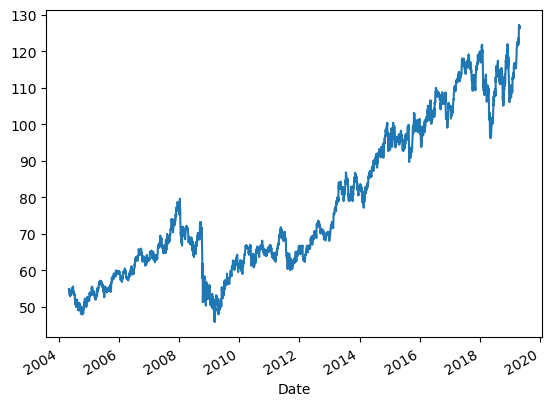

In [6]:
sp_df_15["Close"].plot()

In [7]:
len(sp_df_15)

3773

In [8]:
np.random.seed(123)
results_2h_5f = pipeline_feature_selection(sp_df_2, 2, 5)
results_2h_15f = pipeline_feature_selection(sp_df_2, 2, 15)
results_2h_30f = pipeline_feature_selection(sp_df_2, 2, 30)
results_2h_60f = pipeline_feature_selection(sp_df_2, 2, 60)

# results_5h_5f = pipeline_feature_selection(sp_df_5, 5, 5)
# results_5h_15f = pipeline_feature_selection(sp_df_5, 5, 15)
# results_5h_30f = pipeline_feature_selection(sp_df_5, 5, 30)
# results_5h_60f = pipeline_feature_selection(sp_df_5, 5, 60)

# results_10h_5f = pipeline_feature_selection(sp_df_10, 10, 5)
# results_10h_15f = pipeline_feature_selection(sp_df_10, 10, 15)
# results_10h_30f = pipeline_feature_selection(sp_df_10, 10, 30)
# results_10h_60f = pipeline_feature_selection(sp_df_10, 10, 60)

# results_15h_5f = pipeline_feature_selection(sp_df_15, 15, 5)
# results_15h_15f = pipeline_feature_selection(sp_df_15, 15, 15)
# results_15h_30f = pipeline_feature_selection(sp_df_15, 15, 30)
# results_15h_60f = pipeline_feature_selection(sp_df_15, 15, 60)

(306, 30) (132, 30)
(306, 1) (132, 1)
H =  2

Forecast =  5

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
(299, 30) (129, 30)
(299, 1) (129, 1)
H =  2

Forecast =  15

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
(289, 30) (124, 30)
(289, 1) (124, 1)
H =  2

Forecast =  30

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, m

[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ...................

[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ...................

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003,

H =  2

Forecast =  60

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=7, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=7, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100

/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.128e+01, tolerance: 2.075e+00
  model = cd_fast.enet_coordinate_descent(


[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=7, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_sam

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [9]:
results_5h_5f = pipeline_feature_selection(sp_df_5, 5, 5)
results_5h_15f = pipeline_feature_selection(sp_df_5, 5, 15)
results_5h_30f = pipeline_feature_selection(sp_df_5, 5, 30)
results_5h_60f = pipeline_feature_selection(sp_df_5, 5, 60)

# results_10h_5f = pipeline_feature_selection(sp_df_10, 10, 5)
# results_10h_15f = pipeline_feature_selection(sp_df_10, 10, 15)
# results_10h_30f = pipeline_feature_selection(sp_df_10, 10, 30)
# results_10h_60f = pipeline_feature_selection(sp_df_10, 10, 60)

# results_15h_5f = pipeline_feature_selection(sp_df_15, 15, 5)
# results_15h_15f = pipeline_feature_selection(sp_df_15, 15, 15)
# results_15h_30f = pipeline_feature_selection(sp_df_15, 15, 30)
# results_15h_60f = pipeline_feature_selection(sp_df_15, 15, 60)

(835, 30) (358, 30)
(835, 1) (358, 1)
H =  5

Forecast =  5

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END .........C=1.5, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END .........C=1.5, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.39999999999

[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ....................C=4.0, gamma=5.0, kernel=linear; total time=   0.0s
[CV] END ....................C=4.0, gamma=5.0, kernel=linear; total time=   0.0s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END .

[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........

[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=7, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ......C=0.8, gamma=8.599999999999987, kernel=linear; total time=   0.0s
[CV] END ......C=0.8, gamma=8.599999999999987, kernel=linear; total time=   0.0s
[CV] END ......C=0.8, gamma=8.599999999999987, kernel=linear; total time=   0.0s
[CV] END C=4.1000000000000005, gamma=5.499999999999998, kernel=linear; total time=   0.0s
[CV] END C=4.1000000000000005, gamma=5.499999999999998, kernel=linear; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=l

[CV] END bootstrap=True, max_depth=4, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, min_samples_leaf=9, min_s

[CV] END bootstrap=False, max_depth=4, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=1, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=1, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END ........C=0.2, gamma=5.6000000000000005, kernel=rbf; total time=   0.0s
[CV] END ........C=0.2, gamma=5.6000000000000005, kernel=rbf; total time=   0.0s
[CV] END ........C=0.2, gamma=5.6000000000000005, kernel=rbf; total time=   0.0s
[CV] END ........C=0.2, gamma=5.6000000000000005, kernel=rbf; total time=   0.0s
[CV] END C=1.7000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s

H =  5

Forecast =  15

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
(817, 30) (351, 30)
(817, 1) (351, 1)
H =  5

Forecast =  30

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_sampl

[CV] END bootstrap=False, max_depth=1, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=1, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=1, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END ......................C=1.8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=1.8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=1.8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, gamma=6.800000000000002, kernel=rbf; total

[CV] END bootstrap=False, max_depth=1, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END ........C=1.7000000000000002, gamma=5.2, kernel=rbf; total time=   0.0s
[CV] END ........C=1.7000000000000002, gamma=5.2, kernel=rbf; total time=   0.0s
[CV] END ........C=1.7000000000000002, gamma=5.2, kernel=rbf; total time=   0.0s
[CV] END ........C=1.7000000000000002, gamma=5.2, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.9, gamma=5.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.9, gamma=5.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.9, gamma=5.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.9, gamma=5.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.9, gamma=5.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.9, gamma=5.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.9, gamma=5.0, kernel=rbf; total time

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=False, max_depth=1, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END ......................C=1.8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.7000000000000002, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.7000000000000002, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END .......C=0.30000000000000004, gamma=5.2, kernel=rbf; total time=   0.0s
[CV] END .......C=0.30000000000000004, gamma=5.2

[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ...................

(796, 30) (342, 30)
(796, 1) (342, 1)
H =  5

Forecast =  60

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] EN

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_l

[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=

In [10]:

results_10h_5f = pipeline_feature_selection(sp_df_10, 10, 5)
results_10h_15f = pipeline_feature_selection(sp_df_10, 10, 15)
results_10h_30f = pipeline_feature_selection(sp_df_10, 10, 30)
results_10h_60f = pipeline_feature_selection(sp_df_10, 10, 60)

# results_15h_5f = pipeline_feature_selection(sp_df_15, 15, 5)
# results_15h_15f = pipeline_feature_selection(sp_df_15, 15, 15)
# results_15h_30f = pipeline_feature_selection(sp_df_15, 15, 30)
# results_15h_60f = pipeline_feature_selection(sp_df_15, 15, 60)

(1715, 30) (736, 30)
(1715, 1) (736, 1)
H =  10

Forecast =  5

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ......C=2.7, gamma=8.799999999999986, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996

[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ...................

[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END .

[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
(1708, 30) (733, 30)
(1708, 1) (733, 1)
H =  10

Forecast =  15

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8

[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=

[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.2999999

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_l

[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ...................

(1698, 30) (728, 30)
(1698, 1) (728, 1)
H =  10

Forecast =  30

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, min_sampl

[CV] END .........C=1.8, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.8, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.8, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.8, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.8, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END ...................

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
(1677, 30) (719, 30)
(1677, 1) (719, 1)
H =  10

Forecast =  60

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END .....................C=1.3, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .....................C=1.3, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .........C=1.1, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.1, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.9, gamma=5.0, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.9, gamma=5.0, kernel=rbf; total time=   0.1s
[CV] END .........C=1.5, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END .........C=1.5, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END .........C=1.5, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END ........

[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.1s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END .

[CV] END ........C=1.7000000000000002, gamma=5.2, kernel=rbf; total time=   0.1s
[CV] END ........C=1.7000000000000002, gamma=5.2, kernel=rbf; total time=   0.1s
[CV] END ........C=1.7000000000000002, gamma=5.2, kernel=rbf; total time=   0.1s
[CV] END ........C=1.7000000000000002, gamma=5.2, kernel=rbf; total time=   0.1s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.1s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.1s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.1s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf;

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91,

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001,

In [11]:
results_15h_5f = pipeline_feature_selection(sp_df_15, 15, 5)
results_15h_15f = pipeline_feature_selection(sp_df_15, 15, 15)
results_15h_30f = pipeline_feature_selection(sp_df_15, 15, 30)
results_15h_60f = pipeline_feature_selection(sp_df_15, 15, 60)

(2596, 30) (1113, 30)
(2596, 1) (1113, 1)
H =  15

Forecast =  5

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END .........C=1.1, gamma=6.200000000000001, kernel=rbf; total time=   0.1s
[CV] END .........C=1.1, gamma=6.200000000000001, kernel=rbf; total time=   0.1s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.1s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.1s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; 

[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=11, min_

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.4s


[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=7, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=7, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samp

(2589, 30) (1110, 30)
(2589, 1) (1110, 1)
H =  15

Forecast =  15

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=6, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=6, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=1, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END C=0.6000000000000001, gamma=6.20000000000

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.1s
[CV] END ......C=2.7, gamma=8.799999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=2.7, gamma=8.799999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=2.7, gamma=8.799999999999986, kernel=linear; total time=   0.1s
[CV] END ......C=2.7, gamma=8.799999999999986, kernel=linear; total time=   0.1s
[CV] END C=1.2000000000000002, gamma=5.399999999999999, kernel=linear; total time=

Fitting 10 folds for each of 20 candidates, totalling 200 fits
(2578, 30) (1106, 30)
(2578, 1) (1106, 1)
H =  15

Forecast =  30

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ....................C=4.0, gamma=5.0, kernel=linear; total time=   0.0s
[CV] END ....................C=4.0, gamma=5.0, kernel=linear; total time=   0.1s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.

[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=11, min_sa

[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] EN

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0

(2557, 30) (1097, 30)
(2557, 1) (1097, 1)
H =  15

Forecast =  60

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_sampl

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91,

[CV] END bootstrap=False, max_depth=1, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=1, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END ......................C=1.8, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .........C=0.1, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END C=1.7000000000000002, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.7000000000000002, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END ........C=0.2, gamma=5.6000000000000005, kernel=rbf; total time=   0.0s
[CV] END ........C=0.2, gamma=5.6000000000000005, kernel=rbf; total time=   0.0s
[CV] END ........C=0.2,

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.2s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.2s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.1s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.1s
[CV] END ......C=2.7, gamma=8.79

In [12]:
import pandas as pd

def create_results_dataframe(results, h, f):
    data = []
    columns = [
        "Model", "Historical data", "Forecast", "Mean Residual",
        "Train MAPE (Biased)", "Test MAPE (Biased)",
        "Train MAPE (Unbiased)", "Test MAPE (Unbiased)",
        "Train RMSE (Biased)", "Test RMSE (Biased)",
        "Train RMSE (Unbiased)", "Test RMSE (Unbiased)", "MAPE zero residuals val", "std_ratio_test", "std_ratio_val", "Ranking"
    ]
    
    for i in range(len(results["model"])):
        model = results["model"][i]
        mean_residual = results["mean residual"][i]
        train_mape_biased = results["train MAPE"][i]
        test_mape_biased = results["test MAPE"][i]
        train_mape_unbiased = results['MAPE zero residuals train'][i]
        test_mape_unbiased = results['MAPE zero residuals test'][i]
        train_rmse_biased = results["train RMSE"][i]
        test_rmse_biased = results["test RMSE"][i]
        train_rmse_unbiased = results['RMSE zero residuals train'][i]
        test_rmse_unbiased = results['RMSE zero residuals test'][i]
        val_mape = results["MAPE zero residuals val"][i]
        std_r_val = results["std_ratio_val"]
        std_r_test = results["std_ratio_test"]
        features = results["ranking"]
        row = [
            model, h, f, mean_residual,
            train_mape_biased, test_mape_biased,
            train_mape_unbiased, test_mape_unbiased,
            train_rmse_biased, test_rmse_biased,
            train_rmse_unbiased, test_rmse_unbiased, val_mape, std_r_val, std_r_test, features
        ]
        data.append(row)
    
    df = pd.DataFrame(data, columns=columns)
    lower_mape_unbiased = df["Test MAPE (Unbiased)"].min()
    lower_mape_val = df["MAPE zero residuals val"].min()
    lower_rmse_unbiased = df["Test RMSE (Unbiased)"].min()

    # Find the models with the lowest MAPE and RMSE values
    best_mape_model = df[df["Test MAPE (Unbiased)"] == lower_mape_unbiased]["Model"].iloc[0]
    best_mape_model_val = df[df["MAPE zero residuals val"] == lower_mape_val]["Model"].iloc[0]
    best_rmse_model = df[df["Test RMSE (Unbiased)"] == lower_rmse_unbiased]["Model"].iloc[0]
    
    print(f"Best model based on lower MAPE test unbiased: {best_mape_model}")
    print(f"The Lowest MAPE test unbiased: {round(lower_mape_unbiased,5)}")
    print(f"STD ratio test: {round(std_r_test, 5)}")
    print()
    print()
    print(f"Best model based on lower MAPE val unbiased: {best_mape_model_val}")
    print(f"The Lowest MAPE val unbiased: {round(lower_mape_val,5)}")
    print(f"STD ratio val: {round(std_r_val,5)}")
    print()
    print()
    
    return df

# Example usage
# Replace 'results', 'h', and 'f' with your actual data
results_df_2_5 = create_results_dataframe(results_2h_5f, 2, 5)
results_df_2_5 = create_results_dataframe(results_2h_60f, 2, 60)

Best model based on lower MAPE test unbiased: Naive
The Lowest MAPE test unbiased: 0.01816
STD ratio test: 1.08443


Best model based on lower MAPE val unbiased: Naive
The Lowest MAPE val unbiased: 0.01643
STD ratio val: 1.06506


Best model based on lower MAPE test unbiased: Naive
The Lowest MAPE test unbiased: 0.0472
STD ratio test: 0.70217


Best model based on lower MAPE val unbiased: Naive
The Lowest MAPE val unbiased: 0.04745
STD ratio val: 0.7512




In [13]:
def create_results_dataframe(results, h, f):
    data = []
    columns = [
        "Model", "Historical data", "Forecast", "Mean Residual",
        "Train MAPE (Biased)", "Test MAPE (Biased)",
        "Train MAPE (Unbiased)", "Test MAPE (Unbiased)",
        "Train RMSE (Biased)", "Test RMSE (Biased)",
        "Train RMSE (Unbiased)", "Test RMSE (Unbiased)", "MAPE zero residuals val", "std_ratio_test", "std_ratio_val", "ranking"
    ]
    
    for i in range(len(results["model"])):
        model = results["model"][i]
        mean_residual = results["mean residual"][i]
        train_mape_biased = results["train MAPE"][i]
        test_mape_biased = results["test MAPE"][i]
        train_mape_unbiased = results['MAPE zero residuals train'][i]
        test_mape_unbiased = results['MAPE zero residuals test'][i]
        train_rmse_biased = results["train RMSE"][i]
        test_rmse_biased = results["test RMSE"][i]
        train_rmse_unbiased = results['RMSE zero residuals train'][i]
        test_rmse_unbiased = results['RMSE zero residuals test'][i]
        val_mape = results["MAPE zero residuals val"][i]
        std_r_val = results["std_ratio_val"]
        std_r_test = results["std_ratio_test"]
        ranking = results["ranking"]  # Get the ranking information
        row = [
            model, h, f, mean_residual,
            train_mape_biased, test_mape_biased,
            train_mape_unbiased, test_mape_unbiased,
            train_rmse_biased, test_rmse_biased,
            train_rmse_unbiased, test_rmse_unbiased, val_mape, std_r_val,std_r_test,ranking
        ]
        data.append(row)
        
    
    df = pd.DataFrame(data, columns=columns)
    lower_mape_unbiased = df["Test MAPE (Unbiased)"].min()
    lower_mape_val = df["MAPE zero residuals val"].min()
    lower_rmse_unbiased = df["Test RMSE (Unbiased)"].min()

# Find the models with the lowest MAPE and RMSE values
    best_mape_model = df[df["Test MAPE (Unbiased)"] == lower_mape_unbiased]["Model"].iloc[0]
    best_mape_model_val = df[df["MAPE zero residuals val"] == lower_mape_val]["Model"].iloc[0]
    best_rmse_model = df[df["Test RMSE (Unbiased)"] == lower_rmse_unbiased]["Model"].iloc[0]
    print(f"Best model based on lower MAPE test unbiased: {best_mape_model}")
    print(f"The Lowest MAPE test unbiased: {round(lower_mape_unbiased,5)}")
    print(f"STD ratio test: {round(std_r_test, 5)}")
    print()
    print()
    print(f"Best model based on lower MAPE val unbiased: {best_mape_model_val}")
    print(f"The Lowest MAPE val unbiased: {round(lower_mape_val,5)}")
    print(f"STD ratio val: {round(std_r_val,5)}")
    print()
    print()
#     print(df["ranking"])
    
    return df

# Example usage
# Replace 'results', 'h', and 'f' with your actual data
results_df_2_5 = create_results_dataframe(results_2h_5f, 2, 5)
#results_df_2_5 = create_results_dataframe(results_2h_60f, 2, 60)

Best model based on lower MAPE test unbiased: Naive
The Lowest MAPE test unbiased: 0.01816
STD ratio test: 1.08443


Best model based on lower MAPE val unbiased: Naive
The Lowest MAPE val unbiased: 0.01643
STD ratio val: 1.06506




In [14]:
results_2h_5f['MAPE zero residuals val']

[0.01643383183006021,
 0.020664502902058315,
 0.01643383183006021,
 0.020402225585286336,
 0.017703658657918953,
 0.016460433469383955,
 0.018808852573028206]

In [15]:
results_2h_60f['MAPE zero residuals val']

[0.04745379631104465,
 0.1171032907294991,
 0.06411030448686121,
 0.06411436927861841,
 0.061888655588252954,
 0.06875490378768502,
 0.06794767092341167]

In [16]:
results_df_2_15 = create_results_dataframe(results_2h_15f, 2, 15)

Best model based on lower MAPE test unbiased: SVR, kernel = rbf
The Lowest MAPE test unbiased: 0.03616
STD ratio test: 0.97127


Best model based on lower MAPE val unbiased: SVR, kernel = rbf
The Lowest MAPE val unbiased: 0.03455
STD ratio val: 0.99242




In [17]:
results_df_2_30 = create_results_dataframe(results_2h_30f, 2, 30)


Best model based on lower MAPE test unbiased: SVR, kernel = rbf
The Lowest MAPE test unbiased: 0.06051
STD ratio test: 0.99635


Best model based on lower MAPE val unbiased: SVR, kernel = rbf
The Lowest MAPE val unbiased: 0.05936
STD ratio val: 1.01058




In [18]:
results_df_2_60 = create_results_dataframe(results_2h_60f, 2, 60)

Best model based on lower MAPE test unbiased: Naive
The Lowest MAPE test unbiased: 0.0472
STD ratio test: 0.70217


Best model based on lower MAPE val unbiased: Naive
The Lowest MAPE val unbiased: 0.04745
STD ratio val: 0.7512




In [19]:
results_df_5_5 = create_results_dataframe(results_5h_5f, 5, 5)

Best model based on lower MAPE test unbiased: Naive
The Lowest MAPE test unbiased: 0.01755
STD ratio test: 1.44093


Best model based on lower MAPE val unbiased: Naive
The Lowest MAPE val unbiased: 0.01579
STD ratio val: 1.40376




In [20]:
results_df_5_15 = create_results_dataframe(results_5h_15f, 5, 15)

Best model based on lower MAPE test unbiased: SVR, kernel = rbf
The Lowest MAPE test unbiased: 0.03552
STD ratio test: 1.72796


Best model based on lower MAPE val unbiased: Linear regression
The Lowest MAPE val unbiased: 0.028
STD ratio val: 1.59358




In [21]:
results_df_5_30 = create_results_dataframe(results_5h_30f, 5, 30)

Best model based on lower MAPE test unbiased: Ridge Regularization
The Lowest MAPE test unbiased: 0.05379
STD ratio test: 1.97383


Best model based on lower MAPE val unbiased: Ridge Regularization
The Lowest MAPE val unbiased: 0.03688
STD ratio val: 1.84896




In [22]:
results_df_5_60 = create_results_dataframe(results_5h_60f, 5, 60)

Best model based on lower MAPE test unbiased: SVR, kernel = linear
The Lowest MAPE test unbiased: 0.05971
STD ratio test: 2.17826


Best model based on lower MAPE val unbiased: Linear regression
The Lowest MAPE val unbiased: 0.03453
STD ratio val: 1.66057




In [23]:
results_df_10_5 = create_results_dataframe(results_10h_5f, 10, 5)
results_df_10_5

Best model based on lower MAPE test unbiased: SVR, kernel = linear
The Lowest MAPE test unbiased: 0.01446
STD ratio test: 1.46119


Best model based on lower MAPE val unbiased: Naive
The Lowest MAPE val unbiased: 0.01581
STD ratio val: 1.70962




,Model,Historical data,Forecast,Mean Residual,Train MAPE (Biased),Test MAPE (Biased),Train MAPE (Unbiased),Test MAPE (Unbiased),Train RMSE (Biased),Test RMSE (Biased),Train RMSE (Unbiased),Test RMSE (Unbiased),MAPE zero residuals val,std_ratio_test,std_ratio_val,ranking
0,Naive,10,5,1.293644e-01,0.014676,0.014539,0.014556,0.014466,1.489094,2.174737,1.483465,2.168118,0.015810,1.709625,1.461188,"[[30_rolling_mean, 60_rolling_mean, upper_band..."
1,Linear regression,10,5,-7.126143e-16,0.014419,0.014674,0.014419,0.014674,1.467134,2.197520,1.467134,2.197520,0.016190,1.709625,1.461188,"[[30_rolling_mean, 60_rolling_mean, upper_band..."
2,Lasso REgularization,10,5,0.000000e+00,0.014466,0.014532,0.014466,0.014532,1.473137,2.178037,1.473137,2.178037,0.016108,1.709625,1.461188,"[[30_rolling_mean, 60_rolling_mean, upper_band..."
3,Ridge Regularization,10,5,-1.657243e-17,0.014447,0.014603,0.014447,0.014603,1.468551,2.186348,1.468551,2.186348,0.016324,1.709625,1.461188,"[[30_rolling_mean, 60_rolling_mean, upper_band..."
4,Random Forest Regresssor,10,5,-7.457591e-17,0.011885,0.028091,0.011885,0.028091,1.155877,3.584880,1.155877,3.584880,0.031345,1.709625,1.461188,"[[30_rolling_mean, 60_rolling_mean, upper_band..."
5,"SVR, kernel = rbf",10,5,3.538983e-02,0.004714,0.014597,0.004706,0.014610,0.641995,2.188397,0.641019,2.189886,0.015859,1.709625,1.461188,"[[30_rolling_mean, 60_rolling_mean, upper_band..."
6,"SVR, kernel = linear",10,5,9.238324e-02,0.014430,0.014458,0.014447,0.014461,1.475513,2.172999,1.472618,2.170721,0.015992,1.709625,1.461188,"[[30_rolling_mean, 60_rolling_mean, upper_band..."


In [24]:
results_df_10_15 = create_results_dataframe(results_10h_15f, 10, 15)

Best model based on lower MAPE test unbiased: Ridge Regularization
The Lowest MAPE test unbiased: 0.02687
STD ratio test: 1.71254


Best model based on lower MAPE val unbiased: Ridge Regularization
The Lowest MAPE val unbiased: 0.02863
STD ratio val: 1.95999




In [25]:
results_df_10_30 = create_results_dataframe(results_10h_30f, 10, 30)

Best model based on lower MAPE test unbiased: SVR, kernel = linear
The Lowest MAPE test unbiased: 0.03936
STD ratio test: 1.85013


Best model based on lower MAPE val unbiased: Ridge Regularization
The Lowest MAPE val unbiased: 0.03851
STD ratio val: 2.20475




In [26]:
results_df_10_60 = create_results_dataframe(results_10h_60f, 10, 60)

Best model based on lower MAPE test unbiased: SVR, kernel = linear
The Lowest MAPE test unbiased: 0.04733
STD ratio test: 1.85476


Best model based on lower MAPE val unbiased: SVR, kernel = linear
The Lowest MAPE val unbiased: 0.03593
STD ratio val: 1.79502




In [27]:
results_df_15_5 = create_results_dataframe(results_15h_5f, 15, 5)

Best model based on lower MAPE test unbiased: SVR, kernel = rbf
The Lowest MAPE test unbiased: 0.01501
STD ratio test: 1.49154


Best model based on lower MAPE val unbiased: SVR, kernel = linear
The Lowest MAPE val unbiased: 0.01552
STD ratio val: 1.78373




In [28]:
results_df_15_15 = create_results_dataframe(results_15h_15f, 15, 15)

Best model based on lower MAPE test unbiased: Ridge Regularization
The Lowest MAPE test unbiased: 0.02595
STD ratio test: 1.5327


Best model based on lower MAPE val unbiased: Ridge Regularization
The Lowest MAPE val unbiased: 0.02997
STD ratio val: 1.89135




In [29]:
results_df_15_30 = create_results_dataframe(results_15h_30f, 15, 30)

Best model based on lower MAPE test unbiased: Ridge Regularization
The Lowest MAPE test unbiased: 0.03634
STD ratio test: 1.5575


Best model based on lower MAPE val unbiased: Ridge Regularization
The Lowest MAPE val unbiased: 0.04398
STD ratio val: 2.06893




In [30]:
results_df_15_60 = create_results_dataframe(results_15h_60f, 15, 60)
results_df_15_60

Best model based on lower MAPE test unbiased: SVR, kernel = linear
The Lowest MAPE test unbiased: 0.04204
STD ratio test: 1.37279


Best model based on lower MAPE val unbiased: SVR, kernel = linear
The Lowest MAPE val unbiased: 0.0421
STD ratio val: 1.54827




,Model,Historical data,Forecast,Mean Residual,Train MAPE (Biased),Test MAPE (Biased),Train MAPE (Unbiased),Test MAPE (Unbiased),Train RMSE (Biased),Test RMSE (Biased),Train RMSE (Unbiased),Test RMSE (Unbiased),MAPE zero residuals val,std_ratio_test,std_ratio_val,ranking
0,Naive,15,60,1.075757e+00,0.052664,0.043521,0.050717,0.043400,4.572431,6.232449,4.444083,6.104015,0.045161,1.548268,1.372788,"[[month, 60_rolling_mean, middle_band, lower_b..."
1,Linear regression,15,60,-7.158225e-15,0.049286,0.042641,0.049286,0.042641,4.264116,6.101638,4.264116,6.101638,0.044229,1.548268,1.372788,"[[month, 60_rolling_mean, middle_band, lower_b..."
2,Lasso REgularization,15,60,-2.223051e-16,0.049991,0.042813,0.049991,0.042813,4.373767,6.074985,4.373767,6.074985,0.042970,1.548268,1.372788,"[[month, 60_rolling_mean, middle_band, lower_b..."
3,Ridge Regularization,15,60,-6.224543e-16,0.049281,0.042621,0.049281,0.042621,4.264126,6.098928,4.264126,6.098928,0.044143,1.548268,1.372788,"[[month, 60_rolling_mean, middle_band, lower_b..."
4,Random Forest Regresssor,15,60,1.889259e-02,0.047619,0.043082,0.047608,0.043088,4.098211,5.992761,4.098167,5.994207,0.044859,1.548268,1.372788,"[[month, 60_rolling_mean, middle_band, lower_b..."
5,"SVR, kernel = rbf",15,60,2.210406e-01,0.017336,0.043236,0.017799,0.043199,2.301385,6.118173,2.290745,6.138921,0.045368,1.548268,1.372788,"[[month, 60_rolling_mean, middle_band, lower_b..."
6,"SVR, kernel = linear",15,60,3.060196e-01,0.049325,0.041792,0.049271,0.042035,4.287903,5.981116,4.276969,6.019797,0.042104,1.548268,1.372788,"[[month, 60_rolling_mean, middle_band, lower_b..."


In [37]:
import pandas as pd

# Create a list of your DataFrame names
dataframe_names = ["results_df_2_5", "results_df_2_15", "results_df_2_30", "results_df_2_60",
                   "results_df_5_5", "results_df_5_15", "results_df_5_30", "results_df_5_60",
                   "results_df_10_5", "results_df_10_15", "results_df_10_30", "results_df_10_60",
                   "results_df_15_5", "results_df_15_15", "results_df_15_30", "results_df_15_60"]

dataframe_names = ["results_df_2_5", "results_df_2_15", "results_df_2_30", "results_df_2_60",
                   "results_df_5_5", "results_df_5_15", "results_df_5_30", "results_df_5_60",
                   "results_df_10_5", "results_df_10_15", "results_df_10_30", "results_df_10_60",
                   "results_df_15_5", "results_df_15_15", "results_df_15_30", "results_df_15_60"]

combined_df = pd.DataFrame()

# Iterate through the DataFrame names and concatenate them
for df_name in dataframe_names:
    df = globals()[df_name]  # Fetch the DataFrame by its name
    combined_df = pd.concat([combined_df, df])

# Extract only the desired columns
columns_to_keep = ["Model","Historical data", "Forecast","Mean Residual","Test MAPE (Biased)",  "Test MAPE (Unbiased)", "MAPE zero residuals val","ranking"]
combined_df = combined_df[columns_to_keep]

In [38]:
combined_df.head(30)

,Model,Historical data,Forecast,Mean Residual,Test MAPE (Biased),Test MAPE (Unbiased),MAPE zero residuals val,ranking
0,Naive,2,5,-1.748366e-01,0.017626,0.018161,0.016434,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
1,Linear regression,2,5,-9.473903e-15,0.020828,0.020828,0.020665,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
2,Lasso REgularization,2,5,-7.546614e-17,0.018161,0.018161,0.016434,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
3,Ridge Regularization,2,5,2.322035e-16,0.020496,0.020496,0.020402,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
4,Random Forest Regresssor,2,5,-1.184238e-15,0.019611,0.019611,0.017704,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
5,"SVR, kernel = rbf",2,5,1.543962e-01,0.017699,0.018170,0.016460,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
6,"SVR, kernel = linear",2,5,8.217159e-02,0.019082,0.019426,0.018809,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
0,Naive,2,15,-4.543144e-01,0.035727,0.037655,0.034769,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
1,Linear regression,2,15,-1.425838e-15,0.048337,0.048337,0.053144,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
2,Lasso REgularization,2,15,-1.425838e-16,0.037655,0.037655,0.034769,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."


In [39]:
combined_df.to_csv('combined_results_PEP_before_FS_n.csv', index=True)